First, we load the data:

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 3

metadata_df = pd.read_csv('src/data/metadata.csv')
word_hist_union_raw_df = pd.read_csv('src/data/features/word_histogram_union_raw.csv')
word_hist_union_pruned_df = pd.read_csv('src/data/features/word_histogram_union_pruned.csv')
word_hist_inter_raw_df = pd.read_csv('src/data/features/word_histogram_inter_raw.csv')
word_hist_inter_pruned_df = pd.read_csv('src/data/features/word_histogram_inter_pruned.csv')

# Find all authors
#list_of_authors = list(set(metadata_df['first_author']))
#print(list_of_authors)

Cleaning the data by merging data of aliases of one author:

In [116]:

def merge_authors(author_name, alias):
    """
    In case one author has multiple aliases, merge the data for this author, so all papers are under the name given by author_name
    Example: 'Florentin Millour' and 'F. Millour' are falsely listed as one author
    Also works with two lists of same length, e.g.
    merge_authors(['Florentin Millour', 'James Leftley'], ['F. Millour', 'J. Leftley'])
    """
    new_metadata_df = metadata_df.replace(alias, author_name)
    return new_metadata_df

metadata_df = merge_authors('Florentin Millour', 'F. Millour')

list_of_authors = list(set(metadata_df['first_author']))

We should also check the total word count of each author and remove authors with no data:

In [140]:
def get_paper_ids_for_author(author):
    paper_ids = list(metadata_df.query(f"first_author=='{author}'")["arxiv_id"])
    return paper_ids

def get_word_count_for_author(author, words='all'):
    """
        Gets the total word count for a list of words, if 'all' it will get the total word count of this author
    """
    word_count = 0
    paper_ids = get_paper_ids_for_author(author)
    if len(paper_ids) == 0:
        print(f'Error: could not find papers for {author}')
    else:
        for paper in paper_ids:
            if words== 'all':
                word_row = word_hist_union_raw_df[word_hist_union_raw_df['Data Name'] == float(paper)].values.flatten()
                word_count += int(np.sum(word_row[1:]))
            else:
                for word in words:
                    word_count += int(word_hist_union_raw_df[word_hist_union_raw_df['Data Name'] == float(paper)][word].values[0])
    return int(word_count)

def total_words_by_author():
    author_total_words_dict = {}
    for author in list_of_authors:
        word_count = 0
        paper_ids = get_paper_ids_for_author(author)
        if len(paper_ids) == 0:
            print(f'Error: could not find papers for {author}')
        else:
            for paper in paper_ids:
                word_row = word_hist_union_raw_df[word_hist_union_raw_df['Data Name'] == float(paper)].values.flatten()
                word_count += int(np.sum(word_row[1:]))     
            if word_count == 0:
                print(f'Error: {author} has a word count of 0')
            else:
                author_total_words_dict[author] = word_count
    return author_total_words_dict
    
# We should remove the authors with a total word count of zero:

def remove_authors(author_list):
    new_metadata_df = metadata_df
    for author in author_list:
        i = new_metadata_df[new_metadata_df.first_author==author].index
        new_metadata_df = new_metadata_df.drop(i, axis=0)
    return new_metadata_df

metadata_df = remove_authors(['Violeta Gamez Rosas', 'Emma P. Lieb', 'nan'])
list_of_authors = list(set(metadata_df['first_author']))
#print(list_of_authors)

word_totals = total_words_by_author()
#print(word_totals)

Error: could not find papers for nan


Now we look at the relative word frequencies of each author for all words which occur in every paper (word_hist_inter_raw_df)

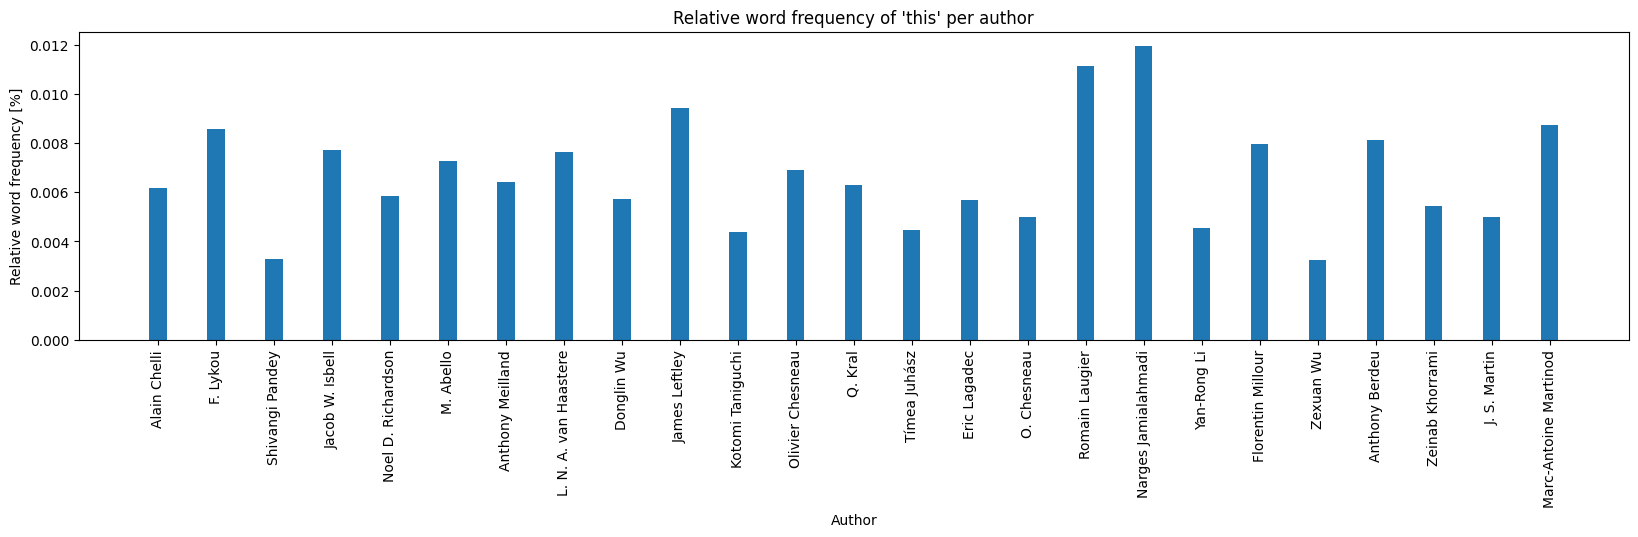

In [167]:
all_intersection_words = list(word_hist_inter_raw_df)[1:]
n_words = len(all_intersection_words)
#print(all_intersection_words)

def make_bar_chart(word):
    frequency_dict = {}
    for author, value in word_totals.items():
        frequency_dict[author] = get_word_count_for_author(author, words=[word])/value
    X = np.array(list(frequency_dict.keys()))
    Y = np.array(list(frequency_dict.values()))
    plt.figure(figsize=(20, 4))
    plt.xlabel("Author")
    plt.ylabel("Relative word frequency [%]")
    plt.xticks(rotation=90)
    plt.title(f"Relative word frequency of '{word}' per author")
    bars = plt.bar(X, Y, width=0.3)
    plt.show()

make_bar_chart('this')
    